In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))    
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())        
        model.add(Activation('relu'))    
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.3959 - acc: 0.1327
Epoch 00001: val_loss improved from inf to 12.84533, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_1_conv_checkpoint/001-12.8453.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 13.3957 - acc: 0.1327 - val_loss: 12.8453 - val_acc: 0.1628
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 12.8406 - acc: 0.1765
Epoch 00002: val_loss did not improve from 12.84533
36805/36805 [==============================] - 74s 2ms/sample - loss: 12.8407 - acc: 0.1765 - val_loss: 13.3236 - val_acc: 0.1421
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 13.8079 - acc: 0.1333
Epoch 00003: val_loss did not improve from 12.84533
36805/36805 [==============================] - 74s 2ms/sample - loss: 13.8082 - acc: 0.1333 - va

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.8332 - acc: 0.2633
Epoch 00028: val_loss did not improve from 12.55189
36805/36805 [==============================] - 74s 2ms/sample - loss: 11.8333 - acc: 0.2633 - val_loss: 12.6921 - val_acc: 0.1861
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.8277 - acc: 0.2638
Epoch 00029: val_loss did not improve from 12.55189
36805/36805 [==============================] - 74s 2ms/sample - loss: 11.8283 - acc: 0.2638 - val_loss: 12.6217 - val_acc: 0.1877
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.8372 - acc: 0.2629
Epoch 00030: val_loss did not improve from 12.55189
36805/36805 [==============================] - 74s 2ms/sample - loss: 11.8374 - acc: 0.2629 - val_loss: 12.9163 - val_acc: 0.1640
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.2873 - acc: 0.2761
Epoch 00031: val_loss improved from 12.55189 to 12.30216, savi

36800/36805 [============================>.] - ETA: 0s - loss: 4.0540 - acc: 0.6857
Epoch 00054: val_loss improved from 8.33372 to 8.25172, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_1_conv_checkpoint/054-8.2517.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 4.0538 - acc: 0.6856 - val_loss: 8.2517 - val_acc: 0.2073
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0565 - acc: 0.7539
Epoch 00055: val_loss improved from 8.25172 to 6.74712, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_1_conv_checkpoint/055-6.7471.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.0573 - acc: 0.7539 - val_loss: 6.7471 - val_acc: 0.2874
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8178 - acc: 0.8024
Epoch 00056: val_loss did not improve from 6.74712
36805/36805 [==============================] - 74s 2ms/sample - loss: 2.8183 - acc: 0.8023 - val_loss: 6.89

36800/36805 [============================>.] - ETA: 0s - loss: 0.1412 - acc: 0.9890
Epoch 00081: val_loss did not improve from 4.56245
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1412 - acc: 0.9890 - val_loss: 5.2833 - val_acc: 0.3583
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1488 - acc: 0.9872
Epoch 00082: val_loss did not improve from 4.56245
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1487 - acc: 0.9872 - val_loss: 5.0191 - val_acc: 0.3767
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9893
Epoch 00083: val_loss did not improve from 4.56245
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1377 - acc: 0.9893 - val_loss: 5.4797 - val_acc: 0.3608
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1448 - acc: 0.9875
Epoch 00084: val_loss did not improve from 4.56245
36805/36805 [========================

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1173 - acc: 0.9910
Epoch 00111: val_loss did not improve from 4.56245
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1173 - acc: 0.9910 - val_loss: 5.4134 - val_acc: 0.3850
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1161 - acc: 0.9917
Epoch 00112: val_loss did not improve from 4.56245
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1161 - acc: 0.9917 - val_loss: 6.2360 - val_acc: 0.3436
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1140 - acc: 0.9918
Epoch 00113: val_loss did not improve from 4.56245
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1145 - acc: 0.9917 - val_loss: 5.4607 - val_acc: 0.3739
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1164 - acc: 0.9910
Epoch 00114: val_loss did not improve from 4.56245
36805/36805 [=======

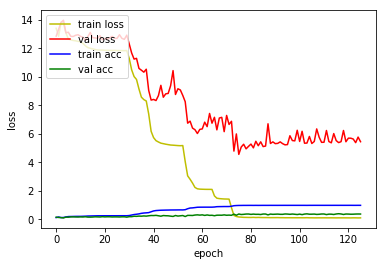

4815/4815 [==============================] - 3s 705us/sample - loss: 4.8689 - acc: 0.3574
Loss: 4.868935505499597 Accuracy: 0.3574247

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.6607 - acc: 0.2915
Epoch 00001: val_loss improved from inf to 4.93758, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_2_conv_checkpoint/001-4.9376.hdf5
36805/36805 [==============================] - 136s 4ms/sample - loss: 4.6606 - acc: 0.2916 - val_loss: 4.9376 - val_acc: 0.2597
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.8210 - acc: 0.4609
Epoch 00002: val_loss improved from 4.93758 to 4.25920, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_2_conv_checkpoint/002-4.2592.hdf5
36805/36805 [==============================] - 131s 4ms/sample - loss: 3.8210 - acc: 0.4609 - val_loss: 4.2592 - val_acc: 0.3853
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 2.5955 - acc: 0.8210
Epoch 00029: val_loss did not improve from 4.25920
36805/36805 [==============================] - 131s 4ms/sample - loss: 2.5956 - acc: 0.8209 - val_loss: 5.9946 - val_acc: 0.4256
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5939 - acc: 0.8235
Epoch 00030: val_loss did not improve from 4.25920
36805/36805 [==============================] - 131s 4ms/sample - loss: 2.5935 - acc: 0.8235 - val_loss: 5.8038 - val_acc: 0.4314
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5959 - acc: 0.8228
Epoch 00031: val_loss did not improve from 4.25920
36805/36805 [==============================] - 131s 4ms/sample - loss: 2.5958 - acc: 0.8228 - val_loss: 6.1477 - val_acc: 0.3986
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5994 - acc: 0.8216
Epoch 00032: val_loss did not improve from 4.25920
36805/36805 [=====================

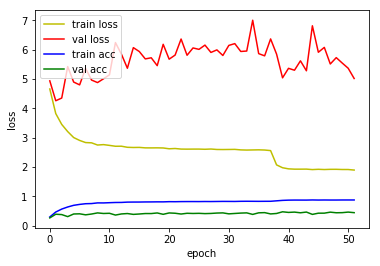

4815/4815 [==============================] - 6s 1ms/sample - loss: 4.2525 - acc: 0.3533
Loss: 4.252515628652286 Accuracy: 0.35327104

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3330 - acc: 0.3440
Epoch 00001: val_loss improved from inf to 2.28626, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_3_conv_checkpoint/001-2.2863.hdf5
36805/36805 [==============================] - 158s 4ms/sample - loss: 2.3330 - acc: 0.3440 - val_loss: 2.2863 - val_acc: 0.3056
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5851 - acc: 0.5265
Epoch 00002: val_loss improved from 2.28626 to 1.54006, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_3_conv_checkpoint/002-1.5401.hdf5
36805/36805 [==============================] - 150s 4ms/sample - loss: 1.5850 - acc: 0.5265 - val_loss: 1.5401 - val_acc: 0.5372
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1195 - acc: 0.9641
Epoch 00029: val_loss did not improve from 1.46817
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.1197 - acc: 0.9641 - val_loss: 2.2182 - val_acc: 0.6138
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1129 - acc: 0.9657
Epoch 00030: val_loss did not improve from 1.46817
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.1129 - acc: 0.9657 - val_loss: 2.0716 - val_acc: 0.6394
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1147 - acc: 0.9640
Epoch 00031: val_loss did not improve from 1.46817
36805/36805 [==============================] - 150s 4ms/sample - loss: 0.1150 - acc: 0.9639 - val_loss: 2.1316 - val_acc: 0.6422
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1152 - acc: 0.9662
Epoch 00032: val_loss did not improve from 1.46817
36805/36805 [========

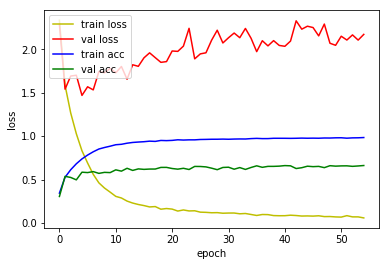

4815/4815 [==============================] - 7s 1ms/sample - loss: 1.5907 - acc: 0.5454
Loss: 1.590722113061669 Accuracy: 0.54537904

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3781 - acc: 0.3308
Epoch 00001: val_loss improved from inf to 1.79391, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_4_conv_checkpoint/001-1.7939.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 2.3780 - acc: 0.3308 - val_loss: 1.7939 - val_acc: 0.4365
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5243 - acc: 0.5360
Epoch 00002: val_loss improved from 1.79391 to 1.27399, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_4_conv_checkpoint/002-1.2740.hdf5
36805/36805 [==============================] - 158s 4ms/sample - loss: 1.5243 - acc: 0.5360 - val_loss: 1.2740 - val_acc: 0.6177
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1898 - acc: 0.9381
Epoch 00028: val_loss did not improve from 0.85323
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.1899 - acc: 0.9381 - val_loss: 1.1034 - val_acc: 0.7419
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1873 - acc: 0.9368
Epoch 00029: val_loss did not improve from 0.85323
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.1873 - acc: 0.9368 - val_loss: 1.0362 - val_acc: 0.7647
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1830 - acc: 0.9406
Epoch 00030: val_loss did not improve from 0.85323
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.1831 - acc: 0.9406 - val_loss: 0.9475 - val_acc: 0.7799
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1784 - acc: 0.9419
Epoch 00031: val_loss did not improve from 0.85323
36805/36805 [========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1018 - acc: 0.9676
Epoch 00058: val_loss did not improve from 0.85323
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.1018 - acc: 0.9676 - val_loss: 1.0734 - val_acc: 0.7866
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0976 - acc: 0.9697
Epoch 00059: val_loss did not improve from 0.85323
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0976 - acc: 0.9697 - val_loss: 1.1052 - val_acc: 0.7796
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0948 - acc: 0.9707
Epoch 00060: val_loss did not improve from 0.85323
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.0948 - acc: 0.9707 - val_loss: 1.0638 - val_acc: 0.7892
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0972 - acc: 0.9695
Epoch 00061: val_loss did not improve from 0.85323
36805/36805 [========

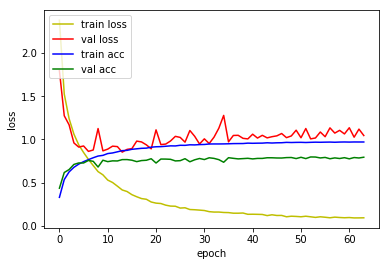

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.9283 - acc: 0.7346
Loss: 0.9282862781859385 Accuracy: 0.73457944

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1927 - acc: 0.3536
Epoch 00001: val_loss improved from inf to 1.58461, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_5_conv_checkpoint/001-1.5846.hdf5
36805/36805 [==============================] - 179s 5ms/sample - loss: 2.1926 - acc: 0.3536 - val_loss: 1.5846 - val_acc: 0.4850
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3643 - acc: 0.5784
Epoch 00002: val_loss improved from 1.58461 to 1.03792, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_5_conv_checkpoint/002-1.0379.hdf5
36805/36805 [==============================] - 163s 4ms/sample - loss: 1.3643 - acc: 0.5784 - val_loss: 1.0379 - val_acc: 0.6832
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2122 - acc: 0.9316
Epoch 00027: val_loss did not improve from 0.60936
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.2122 - acc: 0.9316 - val_loss: 0.7778 - val_acc: 0.8071
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2111 - acc: 0.9319
Epoch 00028: val_loss did not improve from 0.60936
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.2110 - acc: 0.9319 - val_loss: 0.7185 - val_acc: 0.8304
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1951 - acc: 0.9374
Epoch 00029: val_loss did not improve from 0.60936
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.1951 - acc: 0.9374 - val_loss: 0.8723 - val_acc: 0.7827
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1909 - acc: 0.9393
Epoch 00030: val_loss did not improve from 0.60936
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0950 - acc: 0.9707
Epoch 00057: val_loss did not improve from 0.60936
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.0950 - acc: 0.9707 - val_loss: 0.7017 - val_acc: 0.8446
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9711
Epoch 00058: val_loss did not improve from 0.60936
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.0946 - acc: 0.9711 - val_loss: 0.7155 - val_acc: 0.8521
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1029 - acc: 0.9683
Epoch 00059: val_loss did not improve from 0.60936
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.1031 - acc: 0.9683 - val_loss: 0.7461 - val_acc: 0.8442
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0988 - acc: 0.9701
Epoch 00060: val_loss did not improve from 0.60936
36805/36805 [========

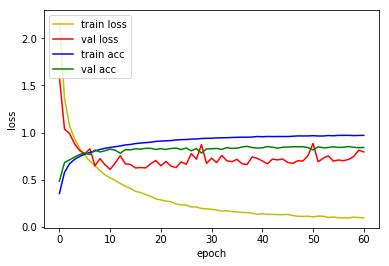

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.7214 - acc: 0.7890
Loss: 0.7214093419745456 Accuracy: 0.7889927

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3659 - acc: 0.2877
Epoch 00001: val_loss improved from inf to 1.94201, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_6_conv_checkpoint/001-1.9420.hdf5
36805/36805 [==============================] - 187s 5ms/sample - loss: 2.3658 - acc: 0.2878 - val_loss: 1.9420 - val_acc: 0.3380
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4102 - acc: 0.5529
Epoch 00002: val_loss improved from 1.94201 to 1.14365, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_6_conv_checkpoint/002-1.1436.hdf5
36805/36805 [==============================] - 165s 4ms/sample - loss: 1.4102 - acc: 0.5529 - val_loss: 1.1436 - val_acc: 0.6553
Epoch 3/500
36800/36805 [============================>.] - ETA:

36800/36805 [============================>.] - ETA: 0s - loss: 0.2099 - acc: 0.9341
Epoch 00025: val_loss improved from 0.36538 to 0.35503, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_6_conv_checkpoint/025-0.3550.hdf5
36805/36805 [==============================] - 166s 4ms/sample - loss: 0.2098 - acc: 0.9341 - val_loss: 0.3550 - val_acc: 0.9073
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1866 - acc: 0.9418
Epoch 00026: val_loss did not improve from 0.35503
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.1867 - acc: 0.9418 - val_loss: 0.3977 - val_acc: 0.9010
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1841 - acc: 0.9413
Epoch 00027: val_loss did not improve from 0.35503
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.1842 - acc: 0.9413 - val_loss: 0.3733 - val_acc: 0.9131
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1

36800/36805 [============================>.] - ETA: 0s - loss: 0.0757 - acc: 0.9762
Epoch 00054: val_loss did not improve from 0.35503
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0757 - acc: 0.9762 - val_loss: 0.3772 - val_acc: 0.9168
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0749 - acc: 0.9767
Epoch 00055: val_loss did not improve from 0.35503
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0749 - acc: 0.9767 - val_loss: 0.4364 - val_acc: 0.9059
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0722 - acc: 0.9770
Epoch 00056: val_loss did not improve from 0.35503
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0722 - acc: 0.9770 - val_loss: 0.4875 - val_acc: 0.8931
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0664 - acc: 0.9786
Epoch 00057: val_loss did not improve from 0.35503
36805/36805 [=====================

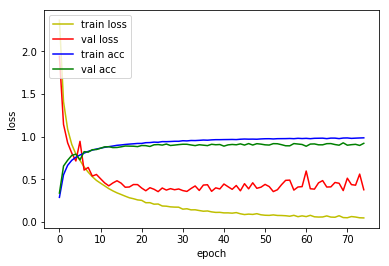

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.4117 - acc: 0.8837
Loss: 0.41169039384226935 Accuracy: 0.8836968

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6147 - acc: 0.2256
Epoch 00001: val_loss improved from inf to 1.94653, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_7_conv_checkpoint/001-1.9465.hdf5
36805/36805 [==============================] - 200s 5ms/sample - loss: 2.6146 - acc: 0.2256 - val_loss: 1.9465 - val_acc: 0.3767
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6163 - acc: 0.4828
Epoch 00002: val_loss improved from 1.94653 to 1.18696, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_7_conv_checkpoint/002-1.1870.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 1.6165 - acc: 0.4828 - val_loss: 1.1870 - val_acc: 0.6294
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 0.1304 - acc: 0.9586
Epoch 00024: val_loss did not improve from 0.19667
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.1304 - acc: 0.9586 - val_loss: 0.2621 - val_acc: 0.9338
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1261 - acc: 0.9599
Epoch 00025: val_loss did not improve from 0.19667
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.1262 - acc: 0.9599 - val_loss: 0.2717 - val_acc: 0.9287
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1216 - acc: 0.9619
Epoch 00026: val_loss did not improve from 0.19667
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.1216 - acc: 0.9619 - val_loss: 0.3168 - val_acc: 0.9210
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1146 - acc: 0.9636
Epoch 00027: val_loss did not improve from 0.19667
36805/36805 [=====================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9884
Epoch 00054: val_loss did not improve from 0.19667
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0382 - acc: 0.9884 - val_loss: 0.2717 - val_acc: 0.9427
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9879
Epoch 00055: val_loss did not improve from 0.19667
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0397 - acc: 0.9879 - val_loss: 0.2637 - val_acc: 0.9422
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0507 - acc: 0.9838
Epoch 00056: val_loss did not improve from 0.19667
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0507 - acc: 0.9838 - val_loss: 0.2279 - val_acc: 0.9474
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9872
Epoch 00057: val_loss did not improve from 0.19667
36805/36805 [========

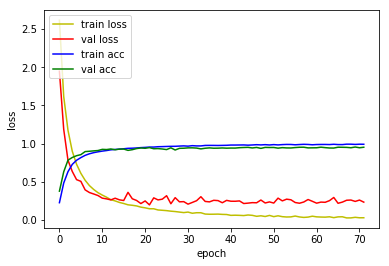

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2422 - acc: 0.9298
Loss: 0.242210166550871 Accuracy: 0.9298027

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6316 - acc: 0.2246
Epoch 00001: val_loss improved from inf to 1.91122, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_8_conv_checkpoint/001-1.9112.hdf5
36805/36805 [==============================] - 214s 6ms/sample - loss: 2.6316 - acc: 0.2246 - val_loss: 1.9112 - val_acc: 0.3890
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5044 - acc: 0.5224
Epoch 00002: val_loss improved from 1.91122 to 0.89534, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_8_conv_checkpoint/002-0.8953.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 1.5045 - acc: 0.5224 - val_loss: 0.8953 - val_acc: 0.7487
Epoch 3/500
36800/36805 [============================>.] - ETA: 

36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0951 - acc: 0.9699 - val_loss: 0.1295 - val_acc: 0.9620
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0828 - acc: 0.9740
Epoch 00025: val_loss did not improve from 0.12950
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0828 - acc: 0.9740 - val_loss: 0.1617 - val_acc: 0.9550
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0792 - acc: 0.9740
Epoch 00026: val_loss did not improve from 0.12950
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0792 - acc: 0.9740 - val_loss: 0.1628 - val_acc: 0.9546
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0743 - acc: 0.9768
Epoch 00027: val_loss did not improve from 0.12950
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0746 - acc: 0.9767 - val_loss: 0.1756 - val_acc: 0.9488
Epoch 28/500
36800/36805 [==============

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9920
Epoch 00054: val_loss did not improve from 0.12892
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0267 - acc: 0.9920 - val_loss: 0.1667 - val_acc: 0.9618
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9894
Epoch 00055: val_loss did not improve from 0.12892
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0316 - acc: 0.9894 - val_loss: 0.1691 - val_acc: 0.9585
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9890
Epoch 00056: val_loss did not improve from 0.12892
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0354 - acc: 0.9889 - val_loss: 0.1797 - val_acc: 0.9602
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9904
Epoch 00057: val_loss did not improve from 0.12892
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0119 - acc: 0.9964
Epoch 00084: val_loss did not improve from 0.12892
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0119 - acc: 0.9964 - val_loss: 0.1498 - val_acc: 0.9660
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0161 - acc: 0.9950
Epoch 00085: val_loss did not improve from 0.12892
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0165 - acc: 0.9949 - val_loss: 0.2325 - val_acc: 0.9543
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0318 - acc: 0.9902
Epoch 00086: val_loss did not improve from 0.12892
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0320 - acc: 0.9902 - val_loss: 0.1693 - val_acc: 0.9623
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9922
Epoch 00087: val_loss did not improve from 0.12892
36805/36805 [========

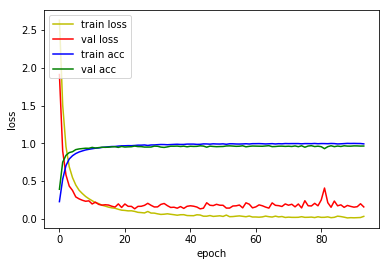

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.1606 - acc: 0.9545
Loss: 0.16056385195406922 Accuracy: 0.9545171

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2377 - acc: 0.3588
Epoch 00001: val_loss improved from inf to 1.34844, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_9_conv_checkpoint/001-1.3484.hdf5
36805/36805 [==============================] - 223s 6ms/sample - loss: 2.2375 - acc: 0.3588 - val_loss: 1.3484 - val_acc: 0.5518
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9646 - acc: 0.6978
Epoch 00002: val_loss improved from 1.34844 to 0.52162, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_9_conv_checkpoint/002-0.5216.hdf5
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.9647 - acc: 0.6977 - val_loss: 0.5216 - val_acc: 0.8428
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0519 - acc: 0.9830
Epoch 00026: val_loss did not improve from 0.13956
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0519 - acc: 0.9830 - val_loss: 0.1592 - val_acc: 0.9585
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9844
Epoch 00027: val_loss improved from 0.13956 to 0.13171, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_9_conv_checkpoint/027-0.1317.hdf5
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0492 - acc: 0.9843 - val_loss: 0.1317 - val_acc: 0.9606
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9815
Epoch 00028: val_loss improved from 0.13171 to 0.12028, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_BN_9_conv_checkpoint/028-0.1203.hdf5
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0594 - acc: 0.9814 

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9965
Epoch 00055: val_loss did not improve from 0.12028
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0132 - acc: 0.9965 - val_loss: 0.2301 - val_acc: 0.9506
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9950
Epoch 00056: val_loss did not improve from 0.12028
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0171 - acc: 0.9950 - val_loss: 0.1719 - val_acc: 0.9627
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0164 - acc: 0.9954
Epoch 00057: val_loss did not improve from 0.12028
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0164 - acc: 0.9954 - val_loss: 0.1658 - val_acc: 0.9637
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9927
Epoch 00058: val_loss did not improve from 0.12028
36805/36805 [========

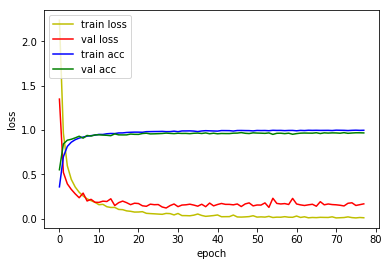

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.1700 - acc: 0.9518
Loss: 0.17004611314828522 Accuracy: 0.9518172



In [10]:
base = '1D_CNN_custom_conv_3_VGG_DO_BN'

for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (N

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.9283 - acc: 0.7346
Loss: 0.9282862781859385 Accuracy: 0.73457944

1D_CNN_custom_conv_3_VGG_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_110 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_111 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (Activation)  

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.4117 - acc: 0.8837
Loss: 0.41169039384226935 Accuracy: 0.8836968

1D_CNN_custom_conv_3_VGG_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_132 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_133 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (Activation)  

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.1606 - acc: 0.9545
Loss: 0.16056385195406922 Accuracy: 0.9545171

1D_CNN_custom_conv_3_VGG_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_162 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_162 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_163 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_163 (Activation) 

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.1700 - acc: 0.9518
Loss: 0.17004611314828522 Accuracy: 0.9518172


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (N

4815/4815 [==============================] - 10s 2ms/sample - loss: 1.2241 - acc: 0.7643
Loss: 1.2240855764872312 Accuracy: 0.7642783

1D_CNN_custom_conv_3_VGG_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_110 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_111 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (Activation)  

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.4791 - acc: 0.8935
Loss: 0.47908884820413244 Accuracy: 0.89345795

1D_CNN_custom_conv_3_VGG_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_132 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_133 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (Activation)

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1914 - acc: 0.9566
Loss: 0.19141455466081975 Accuracy: 0.956594

1D_CNN_custom_conv_3_VGG_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_162 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_162 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_163 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_163 (Activation)  

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2042 - acc: 0.9566
Loss: 0.20422249990356744 Accuracy: 0.956594
